# Vep assessment breakdown


Analysis done to check the contribution of each vep assessment score for lead variants in credible sets


## Methods


In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns


In [3]:
# Set default figure theme
sns.set_theme(
    context="paper",
    palette=sns.set_palette(sns.color_palette("coolwarm")),
    style="whitegrid",
)


def prepare_dataset(df: pl.DataFrame) -> pl.DataFrame:
    """Prefilter based on (7) criteria before the main analysis."""
    initial_n = df.shape[0]
    study_type = pl.col("studyType")

    var_id = pl.col("variantId")

    trait_id = (
        pl.when(study_type == "gwas")
        .then(pl.col("traitFromSourceMappedIds").list.sort().list.join(separator=";"))
        .otherwise(pl.col("geneId"))
        .alias("traitId")
    )
    credible_set_id = pl.concat_str(var_id, trait_id, separator=":").alias("credibleSetId")
    credible_set_id_count = pl.len().over(credible_set_id).alias("credibleSetIdCount")
    df = df.with_columns(var_id, trait_id, credible_set_id, credible_set_id_count)
    # apply filtering
    df = (
        df.filter(pl.col("posteriorProbability") >= 0.9)
        .filter(pl.col("credibleSetIdCount") >= 2)
        .unique(pl.col("credibleSetId"))
    )
    following_n = df.shape[0]
    print(f"Initial number of variants: {initial_n}")
    print(f"Following number of variants: {following_n}")
    print(f"Number of variants removed: {initial_n - following_n}")
    print(f"Percentage of variants removed: {(initial_n - following_n) / initial_n:.2%}")
    return df


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


## Dataset loading


In [4]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet")


In [8]:
data = prepare_dataset(dataset).select(
    pl.col("vepEffect").struct.unnest(),
    classify_by_vep_score(pl.col("vepEffect")),
    adjust_study_type(pl.col("studyType")),
    pl.col("finemappingMethod"),
)
print(data)
data = (
    data.with_columns(cat=pl.concat_str(pl.col("studyType"), separator=" - "), ones=pl.lit(1))
    .group_by("cat", "assessment")
    .agg(pl.sum("ones"), pl.first("normalisedScore"), pl.first("vepScoreClass"))
    .sort("ones")
    .pivot(
        on=["cat"],
        index=["assessment", "normalisedScore", "vepScoreClass"],
        values=["ones"],
        aggregate_function="sum",
    )
    # .fill_null(0)
).sort("normalisedScore", "assessment", descending=True, maintain_order=True)

ordered_cols = sorted(df["studyType"].unique().to_list())
new_names = [f"% {c}" for c in ordered_cols]
print(ordered_cols)
percent = [(pl.col(old) / pl.sum(old) * pl.lit(100)).alias(new) for old, new in zip(ordered_cols, new_names)]
ordered_groups = ["very low", "low", "medium", "high", "very high"]
data = data.select("assessment", *ordered_cols, *percent, "normalisedScore", "vepScoreClass").sort("normalisedScore")
data = data.to_pandas()
assessment_order = data["assessment"]
data


Initial number of variants: 2621048
Following number of variants: 79206
Number of variants removed: 2541842
Percentage of variants removed: 96.98%
shape: (79_206, 6)
┌─────────────────────┬─────────────────┬──────────┬───────────────┬───────────┬───────────────────┐
│ assessment          ┆ normalisedScore ┆ targetId ┆ vepScoreClass ┆ studyType ┆ finemappingMethod │
│ ---                 ┆ ---             ┆ ---      ┆ ---           ┆ ---       ┆ ---               │
│ str                 ┆ f64             ┆ str      ┆ str           ┆ str       ┆ str               │
╞═════════════════════╪═════════════════╪══════════╪═══════════════╪═══════════╪═══════════════════╡
│ intron_variant      ┆ 0.1             ┆ null     ┆ low           ┆ cis-pqtl  ┆ SuSiE-inf         │
│ intron_variant      ┆ 0.1             ┆ null     ┆ low           ┆ eqtl      ┆ SuSie             │
│ intron_variant      ┆ 0.1             ┆ null     ┆ low           ┆ eqtl      ┆ SuSie             │
│ upstream_gene_varia ┆ 0.

,assessment,cis-pqtl,eqtl,gwas,sceqtl,sqtl,trans-pqtl,tuqtl,% cis-pqtl,% eqtl,% gwas,% sceqtl,% sqtl,% trans-pqtl,% tuqtl,normalisedScore,vepScoreClass
0,mature_miRNA_variant,NaN,3,4.0,NaN,NaN,NaN,2.0,NaN,0.008855,0.012545,NaN,NaN,NaN,0.028727,0.00,very low
1,non_coding_transcript_exon_variant,14.0,1736,804.0,26.0,164.0,1.0,189.0,2.321725,5.123816,2.521562,3.719599,3.175218,9.090909,2.714737,0.00,very low
2,upstream_gene_variant,112.0,7013,7760.0,154.0,565.0,3.0,1193.0,18.573798,20.698917,24.337463,22.031474,10.939013,27.272727,17.135880,0.00,very low
3,3_prime_UTR_variant,29.0,1959,1179.0,26.0,140.0,NaN,599.0,4.809287,5.782002,3.697663,3.719599,2.710552,NaN,8.603849,0.10,low
4,5_prime_UTR_variant,16.0,778,261.0,16.0,74.0,NaN,318.0,2.653400,2.296272,0.818567,2.288984,1.432720,NaN,4.567653,0.10,low
5,intron_variant,274.0,20086,16448.0,457.0,3440.0,5.0,3957.0,45.439469,59.283964,51.585385,65.379113,66.602130,45.454545,56.837116,0.10,low
6,splice_donor_region_variant,1.0,105,40.0,3.0,27.0,NaN,21.0,0.165837,0.309908,0.125451,0.429185,0.522749,NaN,0.301637,0.33,medium
7,splice_polypyrimidine_tract_variant,4.0,193,55.0,2.0,63.0,1.0,51.0,0.663350,0.569641,0.172495,0.286123,1.219748,9.090909,0.732548,0.33,medium
8,splice_region_variant,NaN,319,58.0,1.0,87.0,NaN,73.0,NaN,0.941531,0.181904,0.143062,1.684414,NaN,1.048549,0.33,medium
9,stop_retained_variant,NaN,5,NaN,NaN,2.0,NaN,1.0,NaN,0.014758,NaN,NaN,0.038722,NaN,0.014364,0.33,medium


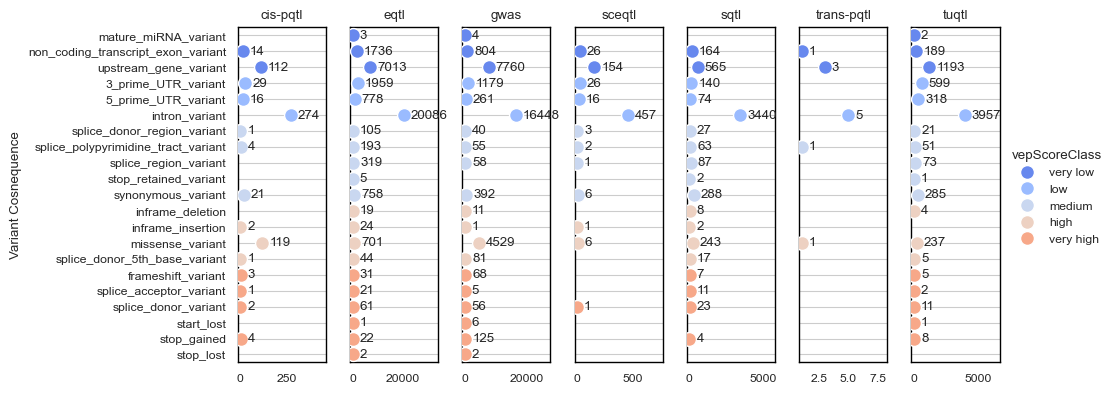

In [ ]:
g = sns.PairGrid(
    data,
    y_vars=["assessment"],
    x_vars=ordered_cols,
    hue="vepScoreClass",
    aspect=0.3,
    height=4,
    dropna=True,
)
g.map(
    sns.stripplot,
    size=10,
    orient="h",
    jitter=True,
    palette="flare_r",
    linewidth=1,
    edgecolor="w",
    order=assessment_order,
)
g.set(ylabel="Variant Cosnequence")
# g.map(plt.pie(x))

titles = ordered_cols

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_xlabel(None)

    for collection in ax.collections:
        offsets = collection.get_offsets()
        for x, y in offsets:
            x_lim_1 = ax.get_xlim()[1]
            # ax.annotate(
            #     f"{round(x, 1):.1f}%", xy=(x, y), xytext=(5, 0), textcoords="offset points", ha="left", va="center"
            # )
            ax.annotate(
                round(x),
                xy=(x, y),
                xytext=(5, 0),
                textcoords="offset points",
                ha="left",
                va="center",
            )
    x_lim = ax.get_xlim()
    ax.set_xlim((x_lim[0], x_lim[1] + 0.6 * x_lim[1]))

sns.despine(left=True, bottom=True)

for ax in g.axes.flatten():  # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True)  # You have to first turn them on
        spine.set_color("black")
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))  # Set the axes background to be transparent


g.add_legend()

g.figure.patch.set_alpha(0)  # Set the figure background to be transparent
plt.show()
